# Projet numérique - Probabilités

On commence par récupérer les calculs du sujet 2020 utiles au sujet 2021.

In [1]:
#Chargement de dépendances
import numpy as np
import matplotlib.pyplot as plt

#Discrétisation
A=0
B=500
N=101 #Nombre de points de discrétisation
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta

#Paramètres du modèle
mu=-5
a = 50
sigma2 = 12

#Données
observation_indexes = [0,20,40,60,80,100]
depth = np.array([0,-4,-12.8,-1,-6.5,0])

#Indices des composantes correspondant aux observations et aux componsantes non observées
unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))

In [2]:
#Fonction C
def Covexp(dist,rangeval,sigmaval):
    return sigmaval * np.exp(-dist/rangeval)

In [3]:
#Matrice de distance
distmat=abs(np.subtract.outer(discretization,discretization))

In [4]:
#Matrice de covariance du vecteur Z
Sigma=Covexp(distmat,a,sigma2)

In [5]:
#Extraction des matrices de covariance utiles depuis la matrice Sigma
SigmaObs = Sigma[observation_indexes,:][:,observation_indexes]
SigmaObsUnknown = Sigma[observation_indexes,:][:,unknown_indexes]
SigmaUnknown = Sigma[unknown_indexes,:][:,unknown_indexes]

In [6]:
#Calcul espérance conditionnelle
Ec= mu+np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),depth-mu))
#Création du profil par la méthode de l'espérance conditionnelle
allval1 = np.zeros(N)
allval1[unknown_indexes]=Ec
allval1[observation_indexes]=depth

In [7]:
#Calcul de la matrice de covariance conditionnelle
SigmaCond = SigmaUnknown - np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),SigmaObsUnknown))

In [8]:
#Fonction de calcul de la longueur de câble nécessaire
def length(z,delta):
    return sum(np.sqrt(Delta**2+(z[1:N]-z[0:-1])**2))

## Valeurs positives

### Question 1

Pour éviter les tirages de profils de profondeur qui présentent des altitudes positives, on utilise la méthode de rejet suivante : tant que tous les points du profil ne sont pas à une altitude négative, on tire à nouveau un profil.

In [9]:
above_0 = True
while above_0 :
    Cholesky = np.linalg.cholesky(SigmaCond)
    x = np.random.normal(0, 1, np.shape(unknown_indexes)[0])
    simu = Ec + np.matmul(Cholesky, x)  
    if all(simu <= 0) :
        above_0 = False

On notera que cette méthode présente un taux de rejet très important. La condition "tous les points du profil ont une altitude négative" est en effet rarement vérifiée, d'où la nécessité d'un grand nombre de tirages (*cf*. le taux de rejet de la méthode calculé ci-après).

On pourrait imaginer une méthode évitant de recalculer tout le profil dès lors qu'il y a un dépassement. Toutefois, à cause du produit matriciel $L\cdot X$ où $X \sim \mathcal{N}(0,\,1)$ et $L$ est la matrice de la décomposition de Cholesky de la matrice de covariance, une dépendance entre les différentes composantes est introduite. Il n'existe donc pas de méthode simple évitant de recalculer intégralement un nouveau profil.

La cellule suivante affiche le profil de profondeur tiré :

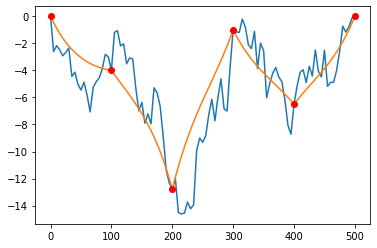

In [10]:
allval3 = np.zeros(N)
allval3[unknown_indexes] = simu
allval3[observation_indexes] = depth
plt.plot(discretization,allval3)
plt.plot(discretization,allval1)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()

### Question 2

**Calcul de la valeur moyenne de la longueur du câble**

In [11]:
#Version avec altitudes positives
K_old = 10000

def sim_result_old(K, N):
    allval30 = np.zeros(N)
    allval30[observation_indexes] = depth
    result_old = np.zeros(K)
    for i in range(K):
        x=np.random.normal(0, 1, np.shape(unknown_indexes)[0])
        allval30[unknown_indexes] = Ec + np.matmul(Cholesky, x)
        result_old[i] = length(allval30, Delta)
    return result_old

result_old = sim_result_old(K_old, N)

In [12]:
#Version sans altitudes positives
K_new = 10000

nb_loop = np.zeros(K_new)
def sim_result_new(K, N):
    allval31 = np.zeros(N)
    allval31[observation_indexes] = depth
    result_new = np.zeros(K)
    for i in range(K):
        above_0 = True
        while above_0 :
            nb_loop[i] += 1
            x=np.random.normal(0, 1, np.shape(unknown_indexes)[0])
            allval31[unknown_indexes] = Ec + np.matmul(Cholesky, x)
            if all(allval31 <= 0):
                above_0 = False
        result_new[i] = length(allval31, Delta)
    return result_new

result_new = sim_result_new(K_new, N)

*Remarque :* On note le temps de calcul bien plus long que dans la version où l'on accepte les altitudes positives. Ce temps de calcul est dû au fort taux de rejet de la méthode utilisée.

La valeur moyenne de la longueur du câble obtenue sur les $K = 10000$ tirages vaut :

In [13]:
sum(result_new)/K_new

521.7833960617314

La longueur moyenne de câble avec la méthode sans rejet était autour de $522.5$ m pour $10 000$ tirages :

In [14]:
sum(result_old)/K_old

522.4721766778556

Quand on interdit les parties émergées, on assiste à une diminution de la valeur moyenne de la longueur du câble. Cela s'explique assez naturellement par le fait que plus le profil du fond marin est régulier, plus le câble a tendance à être court (conséquence de l'inégalité triangulaire). De ce fait, en interdisant certaines anomalies positives, on lisse un peu le profil du fond près de la surface. Toutefois, la différence de longueur moyenne entre les deux méthodes est faible.

**Tracé de l'histogramme des profondeurs obtenues**

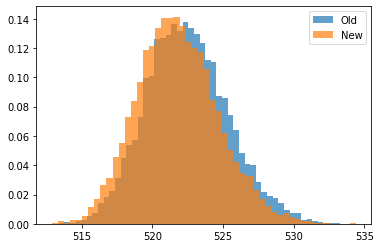

In [15]:
#Affichage des deux distributions de longueur de câble
plt.hist(result_old, 50, density=True,label = "Old", alpha = 0.7)
plt.hist(result_new, 50, density=True,label = "New", alpha = 0.7)
plt.legend()
plt.show()

L'histogramme avec la nouvelle méthode conserve bien une allure gaussienne mais est translaté vers des longueurs de câble plus faibles avec une queue de distribution tronquée à droite (du fait du rejet).

**Intervalle de confiance obtenu par la méthode des quantiles**

In [16]:
np.quantile(result_old,[0.025, 0.975])

array([517.17364065, 528.56309181])

In [17]:
np.quantile(result_new,[0.025, 0.975])

array([516.64820946, 527.66235899])

L'intervalle de confiance est lui aussi translaté vers les valeurs de longueur de câble plus faibles, ce qui est cohérent avec les histogrammes précédents.

**Estimation de la probabilité de dépassement du seuil de 525 m**

In [18]:
np.mean(result_old > 525)

0.1891

In [19]:
np.mean(result_new > 525)

0.1282

Conformément aux résultats précédents, la probabilité que le câble doive mesurer plus que 525 m est plus faible dans le cas où on supprime les altitudes positives.

**Estimation du taux de rejet**

Le taux de rejet est ici la probabilité qu'un profil de profondeur tiré au hasard présente une altitude positive pour au moins un point.

On évalue cette probabilité en observant le nombre de fois que l'on a du passer dans la boucle pour obtenir $K_{new}$ profils de profondeur adpatés. Ce nombre est stocké dans le tableau $nb_{loop}$ (défini dans une cellule précédente).

In [20]:
nb_loop_tot = sum(nb_loop)
tx_rejet = (nb_loop_tot - K_new)/nb_loop_tot

In [21]:
tx_rejet

0.9616066835085348

Le taux de rejet est donc de $96\%$, ce qui est très élevé et explique donc le temps de calcul important de la méthode.

### Question 3

On a : $\forall x=(z,\mu^{*})$,
$$f_{(\mathbf{Z}_{\text{OBS}},\mu)}(x)=f_{\mathbf{Z}_{\text{OBS}}|\mu=\mu^{*}}(z)f_{\mu}(\mu^{*})=f_{\mu|\mathbf{Z}_{\text{OBS}}=\mathbf{z}}(\mu^{*})f_{\mathbf{Z}_{\text{OBS}}}(z)\quad(*)$$
- Dans l'expression ci-dessus, $f_{\mathbf{Z}_{\text{OBS}}|\mu=\mu^{*}}$ la densité utilisée dans la partie I), qui correspond au cas où $\mu$ est fixé, d'où $f_{\mathbf{Z}_{\text{OBS}}|\mu=\mu^{*}}(z)=\frac{1}{(2\pi)^{3}\sqrt{det(C_{OBS})}}\exp(-\frac{1}{2}(z-\mu^{*}\mathbf{1})^T C_{OBS}^{-1}(z-\mu^{*}\mathbf{1}))$, où $\mathbf{1}$ désigne un vecteur de taille 6 constitué que de 1
- D'après l'énoncé, $f_{\mu}(\mu^{*})=\frac{1}{2\sqrt{2\pi}}\exp(-\frac{1}{2}(\frac{\mu^{*}+5}{2})^{2})$
- $\mu$ est gaussien, $Z_{OBS}$ aussi par la partie I), question 3. Donc $\mu|\mathbf{Z}_{\text{OBS}}=\mathbf{z}$ est gaussien. On fixe $\mathbf{z}=\mathbf{z}_{\text{OBS}}$ et on note $f_{\mu|\mathbf{Z}_{\text{OBS}}=\mathbf{z}_{\text{OBS}}}(\mu^{*})=\frac{1}{\sqrt{2\pi}}\frac{1}{\widehat{\sigma}}\exp(-\frac{1}{2}(\frac{\mu^{*}-\widehat{\mu}}{ \widehat{\sigma}})^2)$

Dès lors, en composant $(*)$ par $-2\ln$, on obtient :
$$\alpha+(\mathbf{z}_{\text{OBS}}-\mu^{*}\mathbf{1})^{T}C_{OBS}^{-1}(\mathbf{z}_{\text{OBS}}-\mu^{*}\mathbf{1})+\beta+(\frac{\mu^{*}+5}{2})^{2}=\gamma + (\frac{\mu^{*}-\widehat{\mu}}{\widehat{\sigma}})^{2}+\delta$$
où $\alpha, \beta, \gamma, \delta$ sont des constantes par rapport à $\mu^{*}$, et l'égalité est vraie pour tout $\mu^{*}$.

D'où, $\forall \mu^{*}$ :
$$\alpha+\beta+(\frac{\mu^{*}+5}{2})^{2}+\mathbf{z}_{\text{OBS}}^{T}C^{-1}\mathbf{z}_{\text{OBS}}+(\mu^{*})^{2}\mathbf{1}^{T}C_{OBS}^{-1}\mathbf{1}-\mu^{*}(\mathbf{z}_{\text{OBS}}^{T}C_{OBS}^{-1}\mathbf{1}+\mathbf{1}^{T}C_{OBS}^{-1}\mathbf{z}_{\text{OBS}})$$
$$=\alpha+\beta+(\frac{5}{2})^{2}+\mu^{*}(\frac{5}{2}-\mathbf{z}_{\text{OBS}}^{T}C_{OBS}^{-1}\mathbf{1}-\mathbf{1}^{T}C_{OBS}^{-1}\mathbf{z}_{\text{OBS}})+(\mu^{*})^{2}(\mathbf{1}^{T}C_{OBS}^{-1}\mathbf{1}+\frac{1}{4})$$
$$=\gamma+\delta+\widehat{\mu}^{2}\widehat{\sigma}^{-2}-\mu^{*}\frac{2\widehat{\mu}}{\widehat{\sigma}^{2}}+(\mu^{*})^{2}\widehat{\sigma}^{-2}$$
Ceci étant vrai pour tout $\mu^{*}$, on peut identifier les coefficients des deux polynômes :
$$
\left\{
    \begin{array}{ll}
        \mathbf{1}^{T}C_{OBS}^{-1}\mathbf{1}+\frac{1}{4} = \widehat{\sigma}^{-2}\quad (1)\\
        \mathbf{z}_{\text{OBS}}^{T}C_{OBS}^{-1}\mathbf{1}+\mathbf{1}^{T}C_{OBS}^{-1}\mathbf{z}_{\text{OBS}}-\frac{5}{2}=\frac{2\widehat{\mu}}{\widehat{\sigma}^{2}}\quad (2)
    \end{array}
\right.
$$
Ainsi, par $(1)$, on obtient $\widehat{\sigma}^{2}=(\mathbf{1}^{T}C_{OBS}^{-1}\mathbf{1}+\frac{1}{4})^{-1}$.

$C_{OBS}$ étant symétrique, on a de plus, par $(2)$ : $\widehat{\mu}=\widehat{\sigma}^{2}(\mathbf{1}^{T}C_{OBS}^{-1}\mathbf{z}_{\text{OBS}}-\frac{5}{4})$.

### Question 4

Soient $X$, $Y$ et $Z$ trois vecteurs aléatoires à densité. Soient $x$, $y$, $z$ des éléments de $X(\Omega)$, $Y(\Omega)$, $Z(\Omega)$ respectivement et tel que $f_{Z}(z)>0$. D'après la formule de la densité conditionnelle :
$$f_{X,Y|Z=z}(x,y)=\frac{f_{Z,X,Y}(z,x,y)}{f_{Z}(z)}=\frac{f_{X,(Y,Z)}(x,(y,z))}{f_{Z}(z)}$$
D'où :
$$f_{X,Y|Z=z}(x,y)=\frac{f_{(Y,Z)}(y,z)f_{X|(Y,Z)=(y,z)}(x)}{f_{Z}(z)}=\frac{f_{Y|Z=z}(y)f_{Z}(z)f_{X|(Y,Z)=(y,z)}(x)}{f_{Z}(z)}=f_{Y|Z=z}(y)f_{X|(Y,Z)=(y,z)}(x)$$
D'où l'égalité voulue.

### Question 5

De la question 4, que l'on peut appliquer car $f_{\mathbf{Z}_{\text{OBS}}}(\mathbf{z}_{\text{OBS}}) > 0$, on déduit :
$$f_{(\mathbf{Z}_{\text{UNK}},\mu)|\mathbf{Z}_{\text{OBS}}=\mathbf{z}_{\text{OBS}}}(\mathbf{z}_{\text{UNK}},\mu^{*})=f_{\mathbf{Z}_{\text{UNK}}|\mu=\mu^{*},Z_{OBS}=z_{OBS}}(\mathbf{z}_{\text{UNK}})f_{\mu | \mathbf{Z}_{\text{OBS}}=\mathbf{z}_{\text{OBS}}}(\mu^{*})$$

Or, $\mu | \mathbf{Z}_{\text{OBS}}=\mathbf{z}_{\text{OBS}}$ suit une loi normale $\mathcal{N}(\widehat{\mu},\widehat{\sigma}^2)$. Donc :
$$f_{\mu | \mathbf{Z}_{\text{OBS}}=\mathbf{z}_{\text{OBS}}}(\mu^{*})=\frac{1}{\sqrt{2\pi}\widehat{\sigma}}\exp(-\frac{(\mu^{*}-\widehat{\mu})^{2}}{2\widehat{\sigma}^{2}})$$

De plus, en fixant la valeur de $\mu$ à $\mu^{*}$, on obtient que
$f_{\mathbf{Z}_{\text{UNK}}|\mu=\mu^{*},Z_{OBS}=z_{OBS}}(\mathbf{z}_{\text{UNK}})=f_{\mathbf{Z}_{\text{UNK}}| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(\mathbf{z}_{\text{UNK}})$ en choisissant $\mu=\mu^{*}$ dans cette seconde densité.

Si $\mu=\mu^{*}$, en notant $N$ le nombre total de points :
$$f_{\mathbf{Z}_{\text{UNK}}| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(\mathbf{z}_{\text{UNK}}) = \frac{1}{(2\pi)^{\frac{N-6}{2}}\sqrt{det(S)}}\exp(-\frac{1}{2}(\mathbf{z}_{\text{UNK}}-m_{\mathbf{z}_{\text{UNK}}|\mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}})^{T} S^{-1}(\mathbf{z}_{\text{UNK}}-m_{\mathbf{z}_{\text{UNK}}|\mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}))$$
où $S$ désigne le complément de Schur de la matrice $C_{\text{UNK}}$, *i.e.* $S=C_{\text{UNK}}-C_{\text{UNK},\text{OBS}}C_{\text{OBS}}^{-1}C_{\text{OBS},\text{UNK}}$ et $m_{\mathbf{z}_{\text{UNK}}|\mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}=\mu^{*}\widehat{\mathbf{1}}+C_{\text{UNK},\text{OBS}}C_{\text{OBS}}^{-1}(\mathbf{z}_{\text{OBS}}-\mu^{*}\mathbf{1})$, où $\mathbf{1}$ désigne un vecteur de taille 6 dont tous les coefficients sont égaux à 1 et $\widehat{\mathbf{1}}$ désigne un vecteur de taille $N-6$ avec que des 1.

### Question 6

On calcule les deux paramètres $\widehat{\mu}$ et $\widehat{\sigma}^2$ en appliquant les formules trouvées à la question 3 :

In [22]:
one = np.ones(6)
sigma_chap_2 = 1/(np.matmul(np.matmul(np.transpose(one), np.linalg.inv(SigmaObs)), one) + 1/4)
mu_chap = sigma_chap_2*(np.matmul(np.matmul(np.transpose(one), np.linalg.inv(SigmaObs)), depth) - 5/4)

In [23]:
sigma_chap_2, mu_chap

(1.5368909974762894, -4.291350330933772)

On obtient une valeur pour $\widehat{\mu}$ légèrement supérieure à $-5$ qui est l'espérance *a priori*. De fait la profondeur moyenne sur les observations (calculée ci-dessous) est légèrement supérieure à $-5$, ce qui explique une correction par excès lors de la prise en compte des observations.

In [24]:
np.mean(depth)

-4.05

### Question 7

On calcule la probabilité de $\{\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}} > 0\}$ en utilisant *scipy.stats* et le fait que $\mu | \mathbf{Z}_{\text{OBS}}= \mathbf{z}_{\text{OBS}} \sim \mathcal{N}(\widehat{\mu},\widehat{\sigma}^2)$, d'après la question 3.

In [25]:
import scipy.stats

1 - scipy.stats.norm(mu_chap, sigma_chap_2).cdf(0)

0.002617321506132586

Pour simuler $\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}, \mu <0$, on propose une méthode de rejet :
- générer une valeur de $\mu$ selon la loi $\mathcal{N}(\widehat{\mu},\widehat{\sigma}^2)$,
- si la valeur tirée est positive, on l'ignore, sinon on la prend en compte dans le calcul de la moyenne,
- on itère tant qu'on n'a pas obtenu $N_{val}$ points.

On calcule l'espérance de $\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}, \mu <0$ :

In [26]:
N_val = 10000 #nombre de valeurs que l'on souhaite pour moyenner
res = 0 #somme partielle
nb_val = 0 #nombre de valeurs effectivement retenues

while nb_val < N_val:
    mu = mu_chap + ((sigma_chap_2)**0.5)*np.random.randn()
    if mu < 0:
        res += mu
        nb_val += 1

res = res/N_val
res #valeur approchée de l'espérance

-4.292053482969596

Cette espérance conditionnelle est très proche de $\widehat{\mu}$ ; ce qui est normal puisque $\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$ est positive avec une probabilité très faible (*c.f.* calcul ci-dessus).

### Question 8

Pour générer le couple $\mathbf{Z}_{\text{UNK}}, \mu| \mathbf{Z}_{\text{OBS}}, \mu <0$, on utilise une *méthode de rejets successifs* :
- on tire d'abord un $\mu$ selon la loi normale précédente et on ne le conserve dans la suite qu'à condition qu'il vérifie $\mu<0$,
- une fois $\mu$ tiré, on génère le profil en éliminant tous les profils tels qu'un des points soit à altitude positive.

In [27]:
N = 101

def simulation():

    Cholesky = np.linalg.cholesky(SigmaCond)
    not_emerged = False
    mu = 0.
    founded = False

    while not founded:
        mu = mu_chap + ((sigma_chap_2)**0.5)*np.random.randn()
        if mu < 0.:
            founded = True

    Ec= mu + np.matmul(np.transpose(SigmaObsUnknown), np.matmul(np.linalg.inv(SigmaObs), depth - mu))

    while not not_emerged:
        X = np.random.normal(0, 1, np.shape(unknown_indexes)[0])
        simu = Ec + np.matmul(Cholesky,X)
        if np.all(simu < 0.):
            not_emerged = True

    return simu, mu

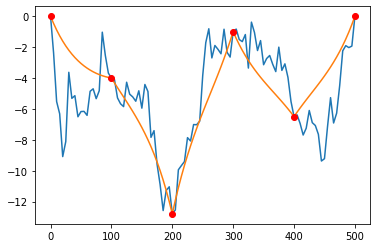

In [28]:
#Affichage d'un profil
allval4 = np.zeros(N)
allval4[unknown_indexes] = simulation()[0]
allval4[observation_indexes] = depth
plt.plot(discretization,allval4)
plt.plot(discretization,allval1)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()

Notons que, d'après la question 7, le premier rejet présente un taux de rejet très faible, car $P(\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}} > 0)\approx 0,003$.

En revanche, le second rejet a un taux de rejet très élevé proche du taux calculé précédemment ($\approx 95\%$).

### Question 9

On génère à présent $K=10000$ profils de profondeur dont on calcule la longueur de câble associée :

In [29]:
K = 10000
def sim_result_final(K, N):
    allval4 = np.zeros(N)
    allval4[observation_indexes] = depth
    result_final = np.zeros(K)
    for i in range(K):
        simu = simulation()[0]
        allval4[unknown_indexes] = simu
        result_final[i] = length(allval4,Delta)
    return result_final

In [30]:
#Simulation des 10000 profils
result_final = sim_result_final(K, N)

**Calcul de la valeur moyenne de la longueur du câble**

La valeur moyenne de la longueur du câble obtenue sur les $K = 10000$ tirages vaut :

In [31]:
sum(result_final)/K_new

521.7233242232039

Les longueurs moyennes de câble avec les deux méthodes précédentes (old et new) étaient :

In [32]:
print(sum(result_old)/K_old)
print(sum(result_new)/K_new)

522.4721766778556
521.7833960617314


Vérifions la convergence de cette valeur moyenne pour chacun des 3 modèles (on utilise chaque fois $K=10000$) :

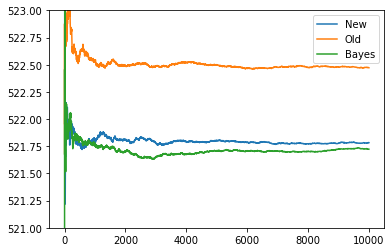

In [33]:
#Tracé graphe convergence
indice_simu = 1 + np.arange(K)
plt.plot(indice_simu,np.cumsum(result_new)/indice_simu, label = 'New')
plt.plot(indice_simu,np.cumsum(result_old)/indice_simu, label = 'Old')
plt.plot(indice_simu,np.cumsum(result_final)/indice_simu, label = 'Bayes')
plt.legend()
plt.ylim(521., 523.)
plt.show()

**Tracé de l'histogramme des profondeurs obtenues**

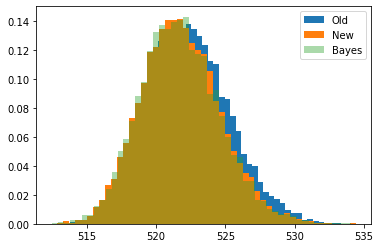

In [35]:
plt.hist(result_old, 50, density = True,label = "Old")
plt.hist(result_new, 50, density = True,label = "New")
plt.hist(result_final, 50, density = True,label = "Bayes", alpha = 0.4)
plt.legend()
plt.show()

**Intervalle de confiance obtenu par la méthode des quantiles**

In [36]:
np.quantile(result_old,[0.025, 0.975])

array([517.17364065, 528.56309181])

In [37]:
np.quantile(result_new,[0.025, 0.975])

array([516.64820946, 527.66235899])

In [38]:
np.quantile(result_final,[0.025, 0.975])

array([516.53761013, 527.68130768])

**Estimation de la probabilité de dépassement du seuil de 525 m**

In [39]:
np.mean(result_old > 525)

0.1891

In [40]:
np.mean(result_new > 525)

0.1282

In [41]:
np.mean(result_final > 525)

0.1242

Tous ces indicateurs montrent que l'approche Bayésienne qui consiste à considérer $\mu$ comme une variable aléatoire conduit à un raffinement de  la moyenne de la longueur de câble calculée. On note toutefois que la différence entre le modèle *new* (rejet des profils à altitude positive) et le modèle *bayes* (approche bayésienne et rejet) est minime.
En particulier, les modifications apportées par la méthode bayésienne induisent des corrections bien moindres que celles apportées par *new* à la version *old*.

### Question 10

Compte tenu des résultats des questions précédentes, on peut supposer q'appliquer une approche bayésienne sur les paramètres $\sigma^2$ et $a$ (les paramètres de la fonction $C$) conduirait à un raffinement de l'estimation de la longueur du câble.
En effet, on constate que la mise en oeuvre d'une approche bayésienne pour $\mu$ a conduit à une légère modification de la longueur moyenne du câble. Cependant cette modification est nettement moins significative que celle induite par l'interdiction des profondeurs positives, ce qui laisse penser qu'il en sera de même pour une approche bayésienne relative à $\sigma^2$ et $a$ : un nouveau raffinement mais peu significatif.